In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sta
from itertools import groupby
import os
import glob

%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Specify file containing behavioral data

In [4]:
df=pd.read_csv('MF319_competition_3_conditions_df_.csv', index_col=0)
df.head()

,animalID,c1,c2,condition,e,expAnimal,experiment,frame,frameCont,l,...,yp2,treatment,xOriginal,yOriginal,front,right,left,r,centerDist,lastStep
0,0.0,1.0,0.0,4,1.0,0.0,0.0,0.0,2800.0,0.0,...,0.630044,0,235.0,430.0,0.0,0.0,0.0,-0.000000,0.0,0.0
1,0.0,1.0,0.0,4,1.0,0.0,0.0,1.0,2801.0,0.0,...,0.630044,0,235.0,430.0,0.0,0.0,0.0,-0.000000,0.0,0.0
2,0.0,1.0,0.0,4,1.0,0.0,0.0,2.0,2802.0,0.0,...,0.630044,0,234.0,430.0,1.0,0.0,1.0,1.834389,1.0,1.0
3,0.0,1.0,0.0,4,1.0,0.0,0.0,3.0,2803.0,0.0,...,0.630044,0,234.0,430.0,1.0,0.0,1.0,1.834389,1.0,0.0
4,0.0,1.0,0.0,4,1.0,0.0,0.0,4.0,2804.0,0.0,...,0.630044,0,234.0,430.0,1.0,0.0,1.0,1.834389,1.0,0.0


In [6]:
df.columns

Index(['animalID', 'c1', 'c2', 'condition', 'e', 'expAnimal', 'experiment',
       'frame', 'frameCont', 'l', 'o', 's1', 's1b', 's2', 's2b', 'trial', 'x',
       'xp1', 'xp2', 'y', 'yp1', 'yp2', 'treatment', 'xOriginal', 'yOriginal',
       'front', 'right', 'left', 'r', 'centerDist', 'lastStep'],
      dtype='object')

In [18]:
df.condition.unique()

array([4, 7, 1])

In [19]:
df.trial.max()

300.0

In [24]:
#specify time limits for analysis, i.e. to exclude very late trials
first_trial=0
last_trial=300

#pull only trials within time limits
dfEarly=df[(df.trial<last_trial)&(df.trial>first_trial)]

#generate a unique ID from animalID and trial number
dfEarly.loc[:,'anTrial']=dfEarly.trial.values + dfEarly.animalID.values*dfEarly.trial.values.max()

# #only consider animals that moved by more than a threshold
ResponseThreshold=30  #should be  around 4mm according to calculations.

ind=(dfEarly.centerDist>=ResponseThreshold)&(dfEarly.frame<=dfEarly.frame.max())
d=dfEarly[ind]


In [28]:
last_frame_stim=15 #last frame for looming presentation for each tRial. End of expansion

In [48]:
#condition 1 is coNdition with right stimu only
#condition 4 is coNdition  with left stimu only
#condition 7 is coNdition with both stimuli (equal stim competition)


x_right_stim=d.x[(d.condition==1)&(d.frame==last_frame_stim)] 
y_right_stim=d.y[(d.condition==1)&(d.frame==last_frame_stim)]
x_left_stim=d.x[(d.condition==4)&(d.frame==last_frame_stim)] 
y_left_stim=d.y[(d.condition==4)&(d.frame==last_frame_stim)]
x_competition=d.x[(d.condition==7)&(d.frame==last_frame_stim)] 
y_competition=d.y[(d.condition==7)&(d.frame==last_frame_stim)]


right_stim=np.stack([x_right_stim,y_right_stim])
left_stim=np.stack([x_left_stim,y_left_stim])
both_stim=np.stack([x_competition,y_competition])


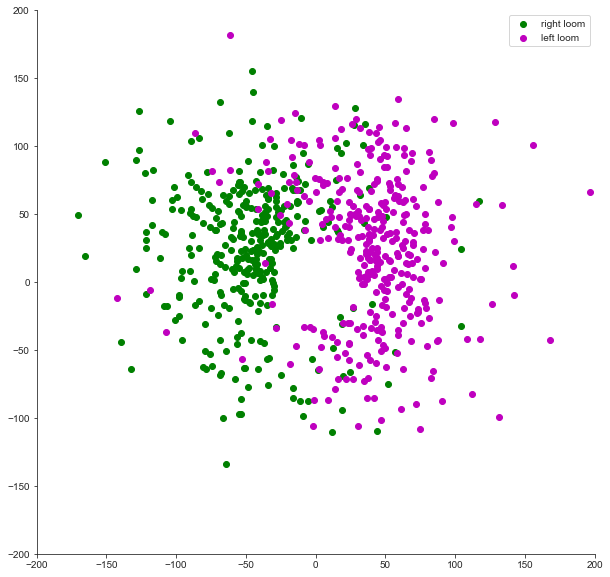

In [76]:
'''Condition with right or left stimuli alone'''

fig = plt.figure(figsize= (10, 10))
plt.scatter(right_stim[0],right_stim[1], color='g',label='right loom')
plt.scatter(left_stim[0],left_stim[1], color='m',label='left loom')
plt.legend(loc='upper right')
plt.xlim(-200,200)
plt.ylim(-200,200)
sns.despine()



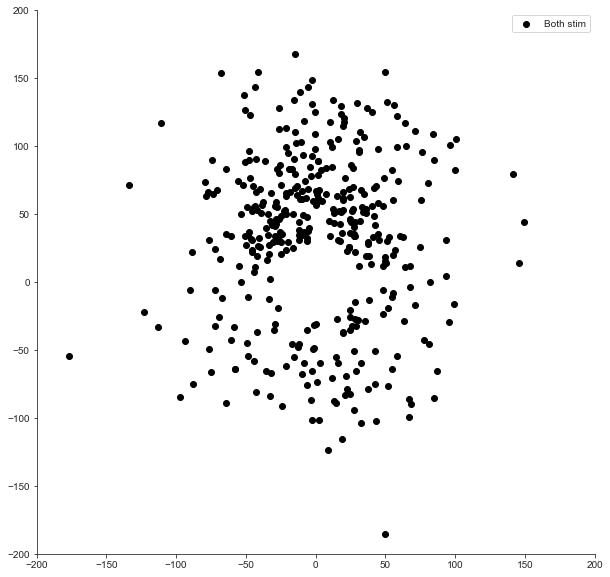

In [79]:
'''Condition with both stimuli'''

fig = plt.figure(figsize= (10, 10))
plt.scatter(both_stim[0],both_stim[1], color='k', label= 'Both stim')
plt.legend(loc='upper right')
plt.xlim(-200,200)
plt.ylim(-200,200)
sns.despine()




# Trying KMeans clustering

# Checking with K to use

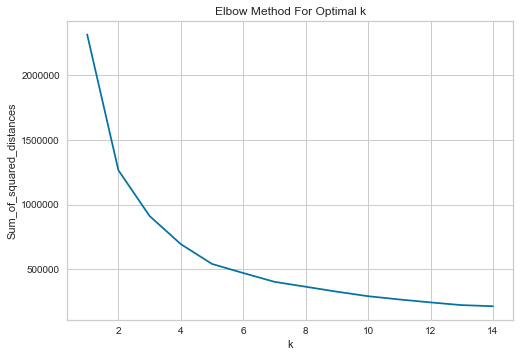

In [111]:
from sklearn.cluster import KMeans
X=np.transpose(both_stim) #transpose to match what is expected for fit

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

(-200, 200)

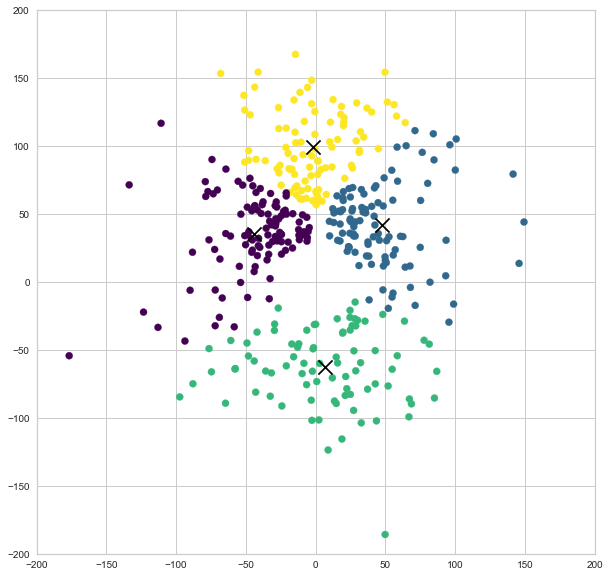

In [117]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

fig = plt.figure(figsize= (10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1, marker='x');


plt.xlim(-200,200)
plt.ylim(-200,200)


# Testing Gaussian mixture model probability distribution
Based on https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

(-200, 200)

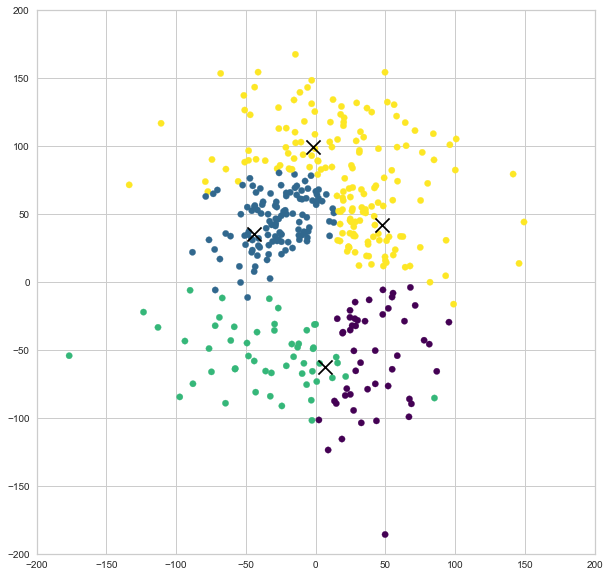

In [118]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
fig = plt.figure(figsize= (10, 10))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1, marker='x');

plt.xlim(-200,200)
plt.ylim(-200,200)


[[0.    0.464 0.    0.536]
 [0.    0.24  0.    0.76 ]
 [0.    0.89  0.    0.11 ]
 [0.003 0.    0.    0.997]
 [0.    0.247 0.    0.753]]


(-200, 200)

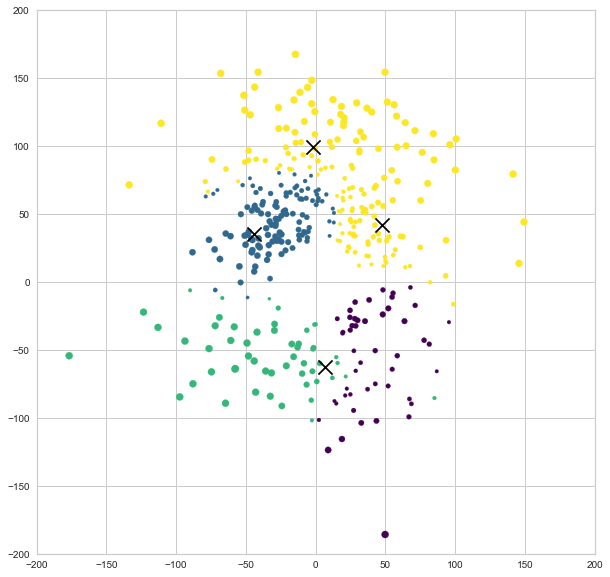

In [123]:
'''find probabilistic cluster assignments'''
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

fig = plt.figure(figsize= (10, 10))
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1, marker='x');
plt.legend
plt.xlim(-200,200)
plt.ylim(-200,200)

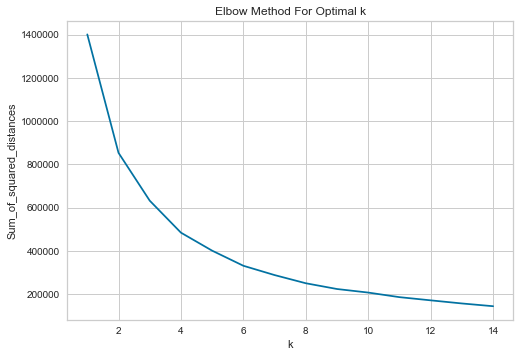

In [132]:
from sklearn.cluster import KMeans
X=np.transpose(right_stim) #transpose to match what is expected for fit

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Comparing clustering methods in a systematic way
Based on https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

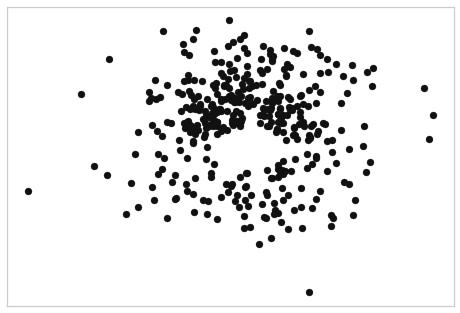

In [136]:
X=np.transpose(equal_stim) #transpose to match what is expected for fit
data=X
plt.scatter(data.T[0], data.T[1], c='k')
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


In [137]:
def plot_clusters(data, algorithm, args, kwds, condition):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    fig = plt.figure(figsize= (10, 10))
    plt.scatter(data.T[0], data.T[1], c=colors)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-150, -150, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    

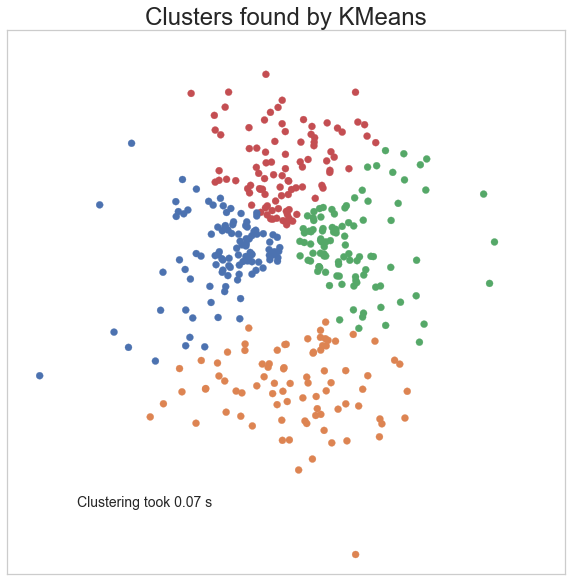

In [138]:
import sklearn.cluster as cluster
import time
plot_clusters(data, cluster.KMeans, (), {'n_clusters':4},'equal_stim')

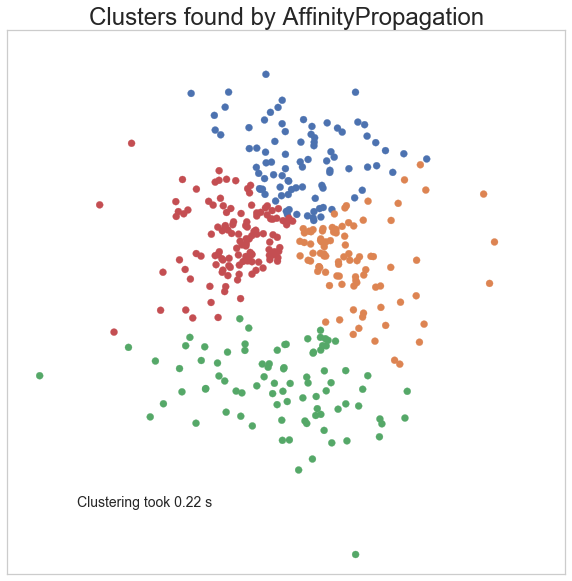

In [144]:
plot_clusters(data, cluster.AffinityPropagation, (),\
              {'preference':-190000, 'damping':.95},'equal_stim')

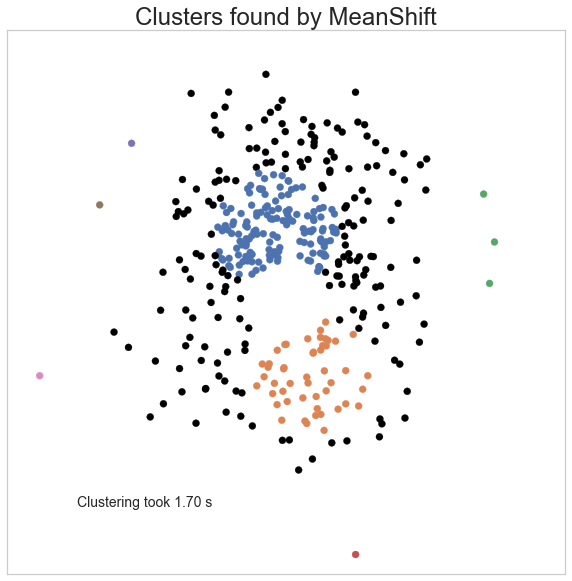

In [146]:
plot_clusters(data, cluster.MeanShift, (45,), {'cluster_all':False},'equal_stim')

/Users/fernandes/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


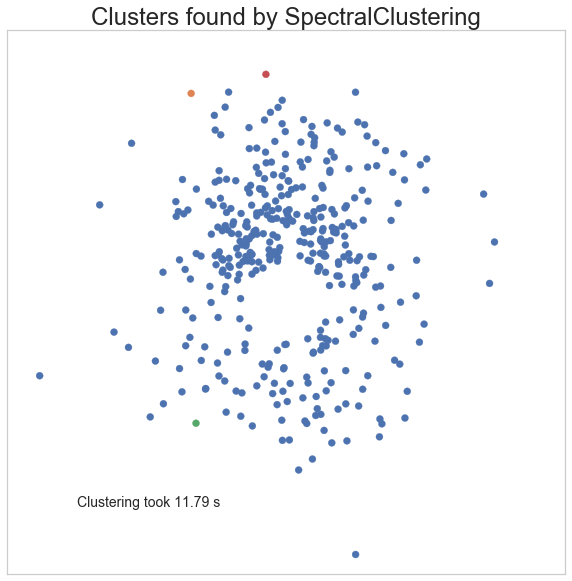

In [147]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':4},'equal_stim')

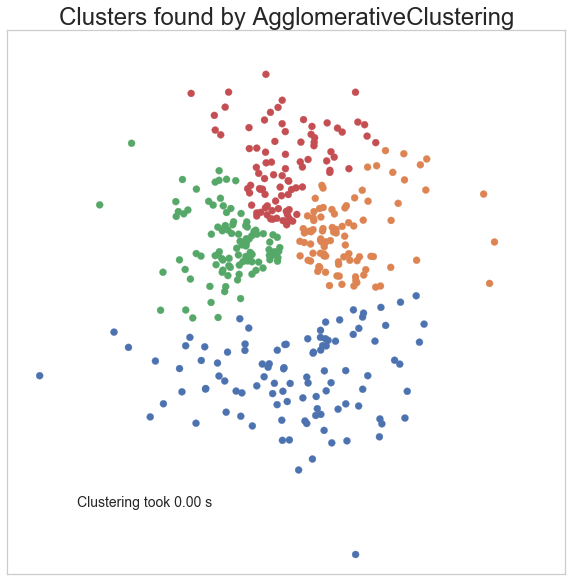

In [148]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':4, 'linkage':'ward'},'equal_stim')


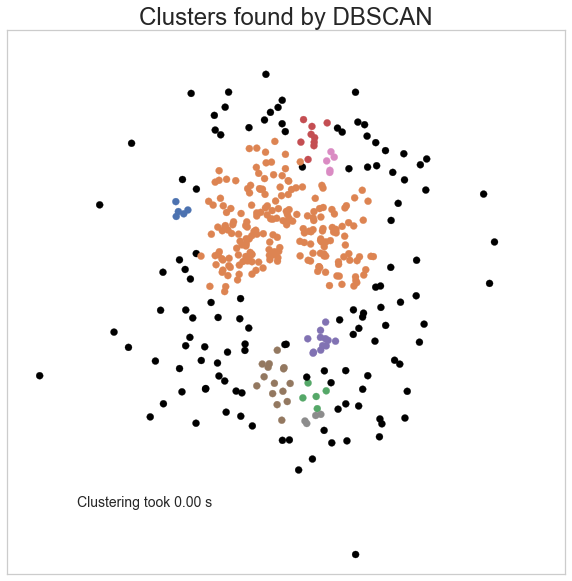

In [149]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':12},'equal_stim')

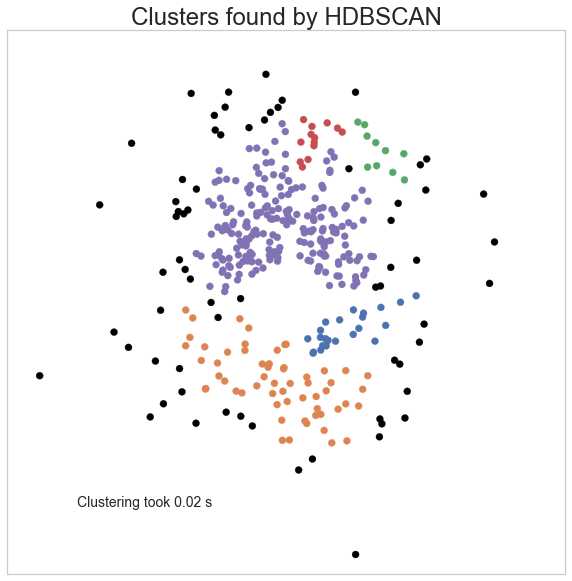

In [151]:
import hdbscan
plot_clusters(data, hdbscan.HDBSCAN, (),{'min_cluster_size':8, 'min_samples':1},'equal_stim')

# Try hierarchical clustering

In [153]:
from scipy.cluster.hierarchy import linkage, dendrogram
samples = X

"""
Perform hierarchical clustering on samples using the
linkage() function with the method='complete' keyword argument.
Assign the result to mergings.
"""
Z= linkage(samples, method='ward')

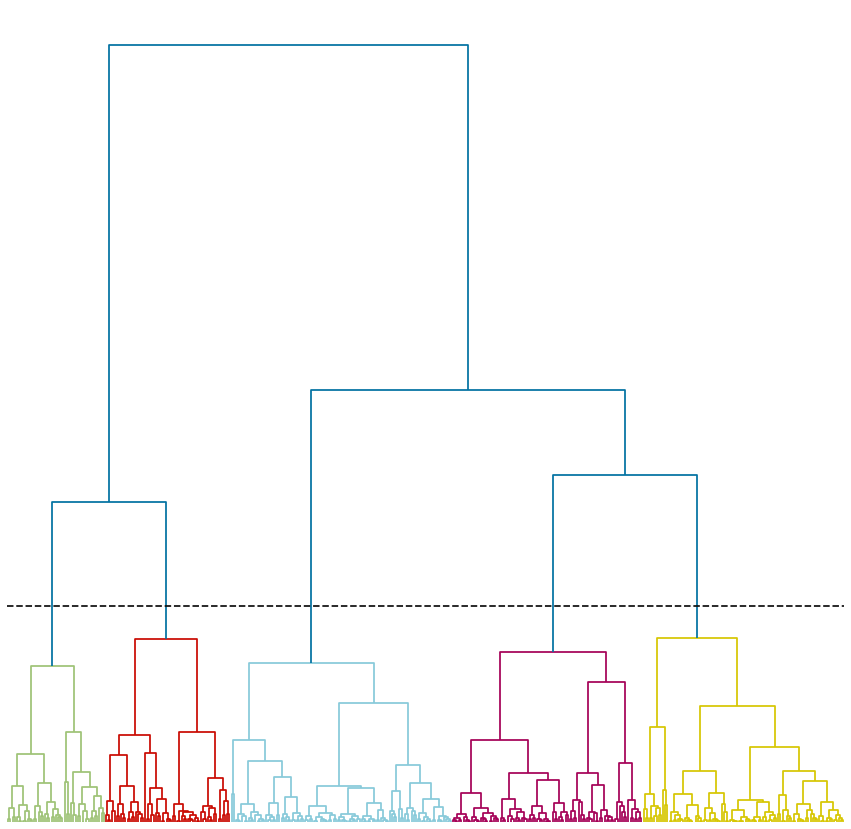

In [155]:
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
import matplotlib as mpl
"""
Plot a dendrogram using the dendrogram() function on mergings,
specifying the keyword arguments labels=varieties, leaf_rotation=90,
and leaf_font_size=6.
"""
cut=400
fig = plt.figure(figsize= (15, 15))

hierarchy.set_link_color_palette(['g', 'r', 'c', 'm', 'y', 'k'])


den=dendrogram(Z,
           leaf_rotation=90,
           leaf_font_size=6,
           color_threshold=cut,)   #define link color func using fcluster ids            
#            truncate_mode='lastp',# show only the last p merged clusters
#            p=50) # show only the last p merged clusters

# print(den['leaves'], den['color_list'])
plt.gcf()
plt.axis('off')
plt.axhline(y=cut, color='k', linestyle='--')


In [156]:
from scipy.cluster.hierarchy import ward, fcluster
cluster_id=fcluster(Z, t=cut, criterion='distance')
cluster_id=cluster_id-1 #cluster_id is relative to samples and is index -1
cluster_id

array([2, 2, 2, 4, 2, 4, 3, 1, 1, 3, 1, 2, 3, 3, 2, 4, 1, 3, 3, 3, 0, 2,
       2, 4, 1, 4, 3, 4, 3, 3, 2, 3, 4, 3, 0, 0, 2, 3, 3, 2, 0, 3, 2, 2,
       3, 4, 2, 4, 2, 4, 0, 2, 3, 2, 0, 2, 4, 3, 0, 2, 2, 2, 4, 3, 1, 2,
       2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 1, 3, 2, 4, 2, 4, 0, 0, 2, 2, 1, 1,
       0, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 4, 0, 0, 3, 3, 3,
       3, 2, 3, 3, 3, 4, 3, 4, 4, 4, 1, 1, 2, 1, 2, 3, 3, 4, 4, 2, 1, 1,
       1, 0, 1, 3, 3, 1, 1, 4, 4, 4, 4, 3, 4, 2, 4, 0, 1, 1, 2, 3, 3, 1,
       3, 1, 1, 0, 4, 1, 0, 3, 0, 3, 0, 1, 0, 2, 4, 2, 2, 0, 0, 3, 2, 1,
       2, 2, 4, 1, 0, 3, 4, 4, 2, 3, 0, 3, 4, 2, 3, 3, 3, 3, 4, 3, 4, 0,
       0, 4, 4, 4, 3, 4, 3, 2, 4, 3, 4, 3, 4, 1, 3, 3, 2, 0, 1, 2, 2, 0,
       2, 3, 4, 2, 2, 4, 3, 2, 4, 0, 4, 4, 2, 4, 0, 1, 4, 4, 2, 3, 3, 4,
       4, 1, 2, 2, 2, 1, 2, 3, 1, 1, 4, 0, 1, 1, 1, 4, 1, 0, 4, 4, 4, 1,
       4, 1, 4, 0, 0, 0, 1, 1, 2, 2, 2, 1, 3, 2, 2, 0, 3, 4, 3, 3, 2, 3,
       1, 3, 2, 2, 4, 2, 3, 4, 3, 2, 2, 2, 4, 4, 2,

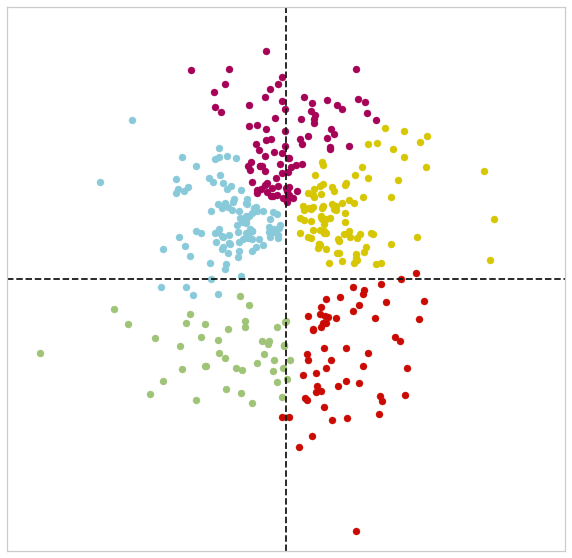

In [158]:
fig = plt.figure(figsize= (10, 10))
plt.scatter(samples[cluster_id ==0,0], samples[cluster_id == 0,1], s=50, c='g')
plt.scatter(samples[cluster_id==1,0], samples[cluster_id== 1,1], s=50, c='r')
plt.scatter(samples[cluster_id ==2,0], samples[cluster_id == 2,1], s=50, c='c')
plt.scatter(samples[cluster_id ==3,0], samples[cluster_id == 3,1], s=50, c='m')
plt.scatter(samples[cluster_id ==4,0], samples[cluster_id == 4,1], s=50, c='y')
frame = plt.gca()
plt.legend
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.vlines(0,-200,200, linestyles="dashed")
plt.hlines(0,-200,200, linestyles="dashed")

frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)



In [159]:
left=samples[cluster_id ==2].shape[0]
back=samples[cluster_id ==0].shape[0]+samples[cluster_id ==1].shape[0]
right=samples[cluster_id ==4].shape[0]
front=samples[cluster_id ==3].shape[0]
total_responses=np.sum([left,back,right,front])

In [212]:
print ('% left', left/total_responses*100)
print ('% right', right/total_responses*100)
print ('% front', front/total_responses*100)

print ('% left + right together', (left+right)/total_responses*100)
print ('% back together', back/total_responses*100)

% left 26.42487046632124
% right 24.093264248704664
% front 22.797927461139896
% left + right together 50.51813471502591
% back together 26.683937823834196


# Conclusions:
Clustering is NOT a good approach for this behavioral data. Boundaries seem arbitrary. Need to model the data in a continuous space (circular data)